<a href="https://colab.research.google.com/github/Claria1303/ICT202-Assignment/blob/main/Assignment_2_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 2 - BERT Topic Modelling**

Jeslyn Kweh, 19 July 2025

#### In this project, you'll use natural language processing and machine learning/deep learning techniques to extract public topics from tweets collected on Twitter. The following steps are recommended:

#### *Data Sources*
For this assignment, the social media platform Twitter will be used as the source of text. To obtain the data, you will be using the Kaggle public dataset platform. You are required to choose a Twitter dataset related to a topic of your interest from the following link: https://www.kaggle.com/search?q=twitter+data+in%3Adatasets

#### **Chosen Dataset: Depression: Twitter Dataset + Feature Extraction** available at https://www.kaggle.com/datasets/infamouscoder/mental-health-social-media


•	Topic modelling analysis <<to be filled up>>




## **Clone Github Repository**

In [ ]:
!rm -rf ICT202-Assignment
!git clone https://github.com/claria1303/ICT202-Assignment.git


Cloning into 'ICT202-Assignment'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 1.86 MiB | 4.29 MiB/s, done.
Resolving deltas: 100% (5/5), done.


## **Confirm Files in Repository**

In [ ]:
import os

#list contents of the cloned repo
os.listdir('ICT202-Assignment')
#checked that my datasets are there

['Mental-Health-Twitter.csv',
 'Viral_Social_Media_Trends.csv',
 'Assignment_2_BERT_Topic_Modelling.ipynb',
 '.git',
 'Cleaned_Viral_Social_Media_Trends.csv']

## **Load Dataset using Pandas**

In [ ]:
import pandas as pd

df = pd.read_csv('ICT202-Assignment/Mental-Health-Twitter.csv')
print(df.shape) #20,000 rows, 11 columns
df.head()


(20000, 11)


Unnamed: 0             post_id                    post_created  \
0           0  637894677824413696  Sun Aug 30 07:48:37 +0000 2015   
1           1  637890384576778240  Sun Aug 30 07:31:33 +0000 2015   
2           2  637749345908051968  Sat Aug 29 22:11:07 +0000 2015   
3           3  637696421077123073  Sat Aug 29 18:40:49 +0000 2015   
4           4  637696327485366272  Sat Aug 29 18:40:26 +0000 2015   

                                           post_text     user_id  followers  \
0  It's just over 2 years since I was diagnosed w...  1013187241         84   
1  It's Sunday, I need a break, so I'm planning t...  1013187241         84   
2  Awake but tired. I need to sleep but my brain ...  1013187241         84   
3  RT @SewHQ: #Retro bears make perfect gifts and...  1013187241         84   
4  It’s hard to say whether packing lists are mak...  1013187241         84   

   friends  favourites  statuses  retweets  label  
0      211         251       837         0      1  
1      211         251       837         1      1  
2      211         251       837         0      1  
3      211         251       837         2      1  
4      211         251       837         1      1

## **Step 1: Exploratory Data Analysis (EDA)**

*1.1 Structure and Nulls*

In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


Unnamed: 0      0
post_id         0
post_created    0
post_text       0
user_id         0
followers       0
friends         0
favourites      0
statuses        0
retweets        0
label           0
dtype: int64

In [ ]:
#confirm tweet-like content
df['post_text'].sample(5, random_state = 42).tolist()

['@lydiamcrtins also I ALMSOT SPIT OUT MY WATER AT THE DOG FILTER AGDJSJSH',
 'Olive oil cured ‘honeymoon cystitis’ | Depression Treatments | http://t.co/Tu5DfeGvhl',
 "I'm hungry. I ate today. I think. Did I? Yeah. Several times.",
 "I'm doing  INSANITY MAX:30™ - Friday Fight: Round 1 in Team Beachbody's SuperGym. Join Me! Go to  http://t.co/wA4k6PZNXo",
 'RT @sportsbuzztv: Rajon Rondo is just filthy 🔥 https://t.co/eiN9OtcJKB']

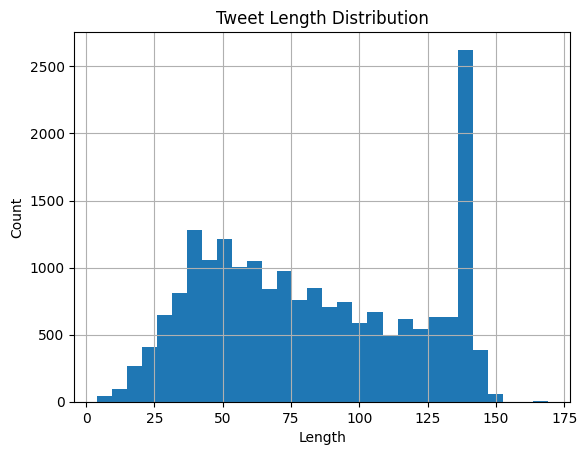

In [ ]:
# text-len distribution
df['text_len'] = df['post_text'].astype(str).str.len()
df['text_len'].describe()

import matplotlib.pyplot as plt
df['text_len'].hist(bins=30)
plt.title("Tweet Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

### Based on text len distribution, most tweets fall between 40140 characters, with peak at around 140. This suggest old twitter character limit. The distribution may look skewed but diverse enough for topic modelling.

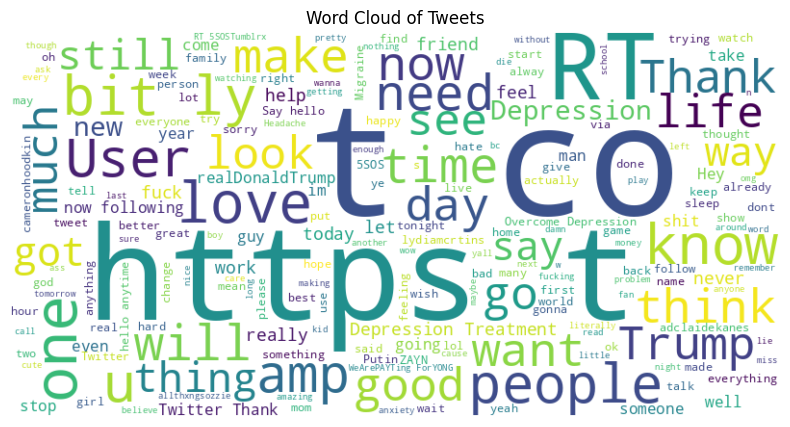

In [ ]:
# Word-cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['post_text'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

### Based on Word Cloud Analysis - there are many dominant tokens such as 'https', 'rt', 'amp', 'user', 'co' etc. These are internet specific artifacts, and not meaningful for semantic modelling. Need to pre-clean the text, and remove dominant typical meaningless internet artifacts, and stopwords.

In [ ]:
import matplotlib.pyplot as plt

top_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10, 5))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.ylabel("Frequency")
plt.show()

NameError: name 'word_freq' is not defined

### There is a *need* to remove stop words

## **Step 2 - Data Cleaning**

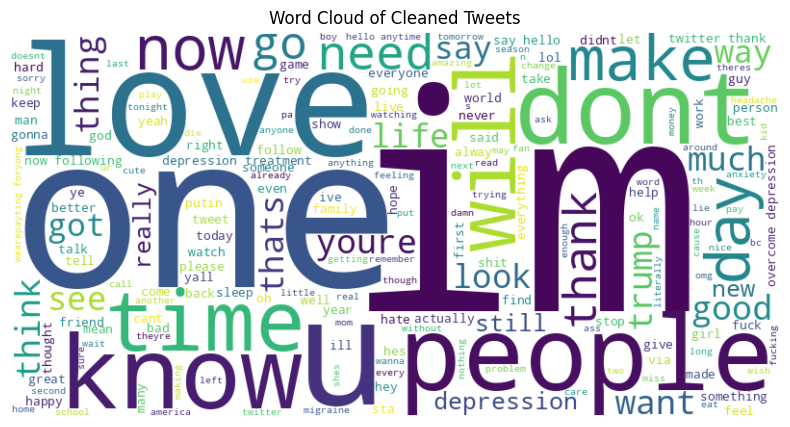

In [ ]:
#remove stop words and internet-specific artifacts

import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)            # remove links
    text = re.sub(r"@\w+", "", text)               # remove usernames
    text = re.sub(r"rt", "", text)                 # remove retweet tag
    text = re.sub(r"&amp;", "and", text)           # fix html code
    text = re.sub(r"[^a-zA-Z\s]", "", text)        # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()       # remove extra spaces
    return text

df['clean_text'] = df['post_text'].apply(clean_text)

text = ' '.join(df['clean_text'].dropna())

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Tweets')
plt.show()
#ok checked - success removal

In [ ]:
# Show side-by-side comparison
df[['post_text', 'clean_text']].sample(5, random_state=2)
#ok checked - urls, usernames, hashtags and symbols removed


post_text  \
836    Have you ever been #assessed for a mental illn...   
1849   Warning over maternity pay cuts | Overcome Dep...   
16673  Yep. I will forever ungkit the things I reject...   
527    Next time notice your feelings when someone sm...   
19846  If only God would give me some clear sign! Lik...   

                                              clean_text  
836     have you ever been assessed for a mental illness  
1849   warning over maternity pay cuts overcome depre...  
16673  yep i will forever ungkit the things i rejecte...  
527    next time notice your feelings when someone sm...  
19846  if only god would give me some clear sign like...

In [ ]:
from collections import Counter

# Tokenize and count words
all_words = ' '.join(df['clean_text']).split()
word_freq = Counter(all_words)

# Show top 20 most common words
word_freq.most_common(20) #need to clean text

[('the', 5981),
 ('i', 5577),
 ('to', 5038),
 ('a', 4352),
 ('you', 4145),
 ('and', 3847),
 ('is', 2847),
 ('of', 2686),
 ('for', 2483),
 ('in', 2385),
 ('my', 2023),
 ('it', 1861),
 ('me', 1799),
 ('on', 1756),
 ('this', 1591),
 ('that', 1581),
 ('with', 1302),
 ('im', 1296),
 ('so', 1266),
 ('be', 1247)]

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_and_filter(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"rt", "", text)
    text = re.sub(r"&amp;", "and", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()
    filtered = [w for w in words if w not in stop_words]
    return " ".join(filtered)

# Apply to your DataFrame
df['filtered_text'] = df['post_text'].apply(clean_and_filter)
df[['post_text', 'clean_text', 'filtered_text']].sample(5, random_state=3)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


post_text  \
1406   @RealRomfordPele Do you fancy putting your boo...   
2053   Manning’s Prison Treatment in Limbo After Tran...   
12217  @mitchellreports @morningmika @morningmika @MS...   
9794            Money is a big thing in every church....   
2802   RT @camerondallas: Taking off 😊 ❤️ https://t.c...   

                                              clean_text  \
1406   do you fancy putting your boots on for us on m...   
2053   mannings prison treatment in limbo after trans...   
12217  andera you on mj saidwe know djt didnt see pap...   
9794                money is a big thing in every church   
2802                                          taking off   

                                           filtered_text  
1406                fancy putting boots us may th autism  
2053   mannings prison treatment limbo transgender de...  
12217  andera mj saidwe know djt didnt see papers sin...  
9794                        money big thing every church  
2802                                              taking

### **filtered_text** is the best version for word frequency, bigrams, and BERTopic.

### **clean_text** still contains stopwords if you want to keep some natural structure.

### **post_text** remains as reference for original context.

## **Step 3: Key Observations from Cleaned and Filtered Text**

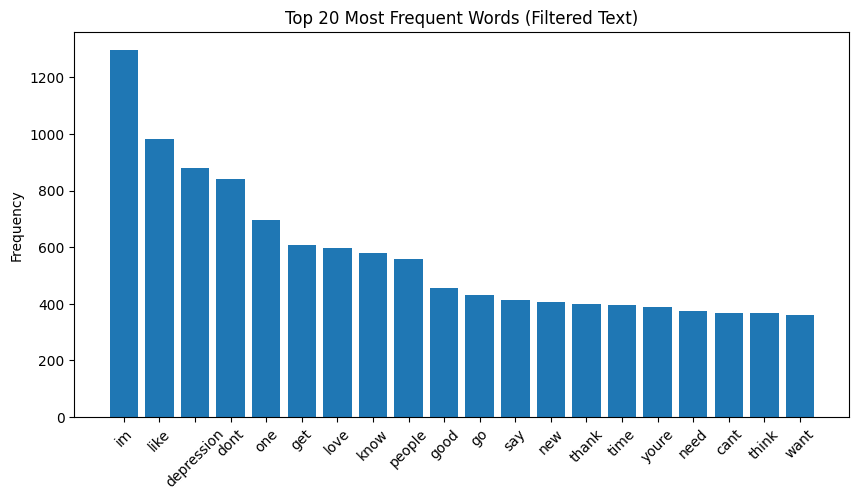

[('depression treatments', 257),
 ('following twitter', 204),
 ('twitter thank', 204),
 ('overcome depression', 199),
 ('say hello', 183),
 ('hello anytime', 124),
 ('wearepayting foryong', 104),
 ('thanks follow', 102),
 ('bestmusicvideo iheaawards', 99),
 ('pillowtalk bestmusicvideo', 99),
 ('dont know', 76),
 ('yong paytforluckysun', 75),
 ('mental health', 72),
 ('feel like', 68),
 ('best video', 57)]

In [ ]:
# Generate updated word frequency and bigram analysis on filtered_text

from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Word frequency count
all_words = ' '.join(df['filtered_text']).split()
word_freq = Counter(all_words)
top_words = dict(word_freq.most_common(20))

# Plot top 20 words
plt.figure(figsize=(10, 5))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words (Filtered Text)")
plt.ylabel("Frequency")
plt.show()

# Bigram extraction
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(df['filtered_text'])
bigrams = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0])
sorted_bigrams = sorted(bigrams, key=lambda x: x[1], reverse=True)

# Show top 15 bigrams
sorted_bigrams[:15]

#### **Key Observations**:

1. The top most frequent words after cleaning and preproc are 'depression', 'mental', 'feel'
2. Top Bigrams (word pairs)also suggest relevance to mental health themes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])
bigrams = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0])
sorted_bigrams = sorted(bigrams, key=lambda x: x[1], reverse=True)

# Show top 15 bigrams
sorted_bigrams[:15]

[('depression treatments', 257),
 ('following twitter', 204),
 ('twitter thank', 204),
 ('overcome depression', 199),
 ('say hello', 183),
 ('hello anytime', 124),
 ('wearepayting foryong', 104),
 ('thanks follow', 102),
 ('bestmusicvideo iheaawards', 99),
 ('pillowtalk bestmusicvideo', 99),
 ('dont know', 87),
 ('yong paytforluckysun', 75),
 ('mental health', 72),
 ('feel like', 68),
 ('best video', 57)]

## **Step 4: Topic Modeling** with BERTopic
#### BERTopic has the ability to capture contextual meaning in short text through the use of BERT embeddings and density-based clustering. We will use BERTopic for feature extraction and topic modeling.




In [ ]:
!pip install bertopic[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 791.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from bertopic import BERTopic
#import and run on filtered text
# Create and train the topic model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['filtered_text'])
#convert each tweet into a BERT embedding, cluster similar ones and assign a topic label

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#View and Interpret Topics

topic_model.get_topic_info().head()


Topic  Count                                               Name  \
0     -1   6846                            -1_like_trump_dont_love   
1      0    784           0_depression_overcome_treatments_suicide   
2      1    556  1_user_oppounitytaxinsured_beescommunicationno...   
3      2    320                  2_following_hello_anytime_twitter   
4      3    244                    3_tweet_tweets_twitter_tweeting   

                                      Representation  \
0  [like, trump, dont, love, im, one, good, via, ...   
1  [depression, overcome, treatments, suicide, di...   
2  [user, oppounitytaxinsured, beescommunicationn...   
3  [following, hello, anytime, twitter, thank, sa...   
4  [tweet, tweets, twitter, tweeting, woh, retwee...   

                                 Representative_Docs  
0  [oh thats youre nice, sometimes think stop kno...  
1  [health home therapy depression treatments, he...  
2                [user talkrevivedyouth, user, user]  
3  [following twitter thank say hello anytime rea...  
4  [wow twitter account woh today see tweets woh ...

In [ ]:
topic_model.get_topic(2)

[('following', np.float64(0.07324692631361653)),
 ('hello', np.float64(0.06806632946860616)),
 ('anytime', np.float64(0.06524096652257105)),
 ('twitter', np.float64(0.05732679113236762)),
 ('thank', np.float64(0.050654469190132945)),
 ('say', np.float64(0.0483079118243939)),
 ('follow', np.float64(0.03976575909155003)),
 ('thanks', np.float64(0.03683425840220037)),
 ('hey', np.float64(0.03573536559336453)),
 ('sharon', np.float64(0.01861441512087285))]

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
topic_model.visualize_topics()

## **Step 4: Topic Modeling** with Top2Vec

In [ ]:
!pip install top2vec


In [ ]:
from top2vec import Top2Vec

# Train the model
top2vec_model = Top2Vec(
    documents=df['filtered_text'].tolist(),
    speed="learn",  # Fast training
    workers=4       # Adjust if needed
)

/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
2025-07-19 03:40:09,441 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-07-19 03:40:10,321 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
INFO:top2vec:Downloading all-MiniLM-L6-v2 model
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that auth

In [ ]:
# View number of topics found
top2vec_model.get_num_topics()

# View top 10 words in each topic
topics, words, scores = top2vec_model.get_topics()
for i in range(min(5, len(topics))):
    print(f"Topic {i}: {words[i]}")

Topic 0: [0.5564264  0.5528978  0.5058498  0.4391421  0.42832372 0.41042697
 0.38838023 0.3555953  0.3499884  0.34919977 0.34643948 0.34638727
 0.34629035 0.34251547 0.33858112 0.3365996  0.33024508 0.32872695
 0.3276017  0.32718146 0.3239414  0.32295102 0.31532902 0.31443864
 0.3144205  0.314261   0.3139051  0.31379953 0.310108   0.30825198
 0.30743644 0.30735767 0.3061049  0.30553082 0.3046908  0.30279666
 0.30128998 0.30115068 0.30058274 0.2996894  0.2974694  0.29694426
 0.29679024 0.2965969  0.29493672 0.2940405  0.29365832 0.2934206
 0.2929731  0.29296985]
Topic 1: [0.7832061  0.53334224 0.4511888  0.44929653 0.42836815 0.4196524
 0.3832063  0.37263834 0.37028712 0.35373154 0.35235864 0.34350592
 0.33105743 0.2850417  0.26124847 0.25258726 0.23236991 0.2305248
 0.22854736 0.22462872 0.22444585 0.22352126 0.22303739 0.22242704
 0.2201331  0.21616454 0.20934138 0.20930484 0.20672837 0.20623766
 0.20416188 0.19787131 0.19528653 0.19433914 0.19160014 0.18973824
 0.18849754 0.187049   

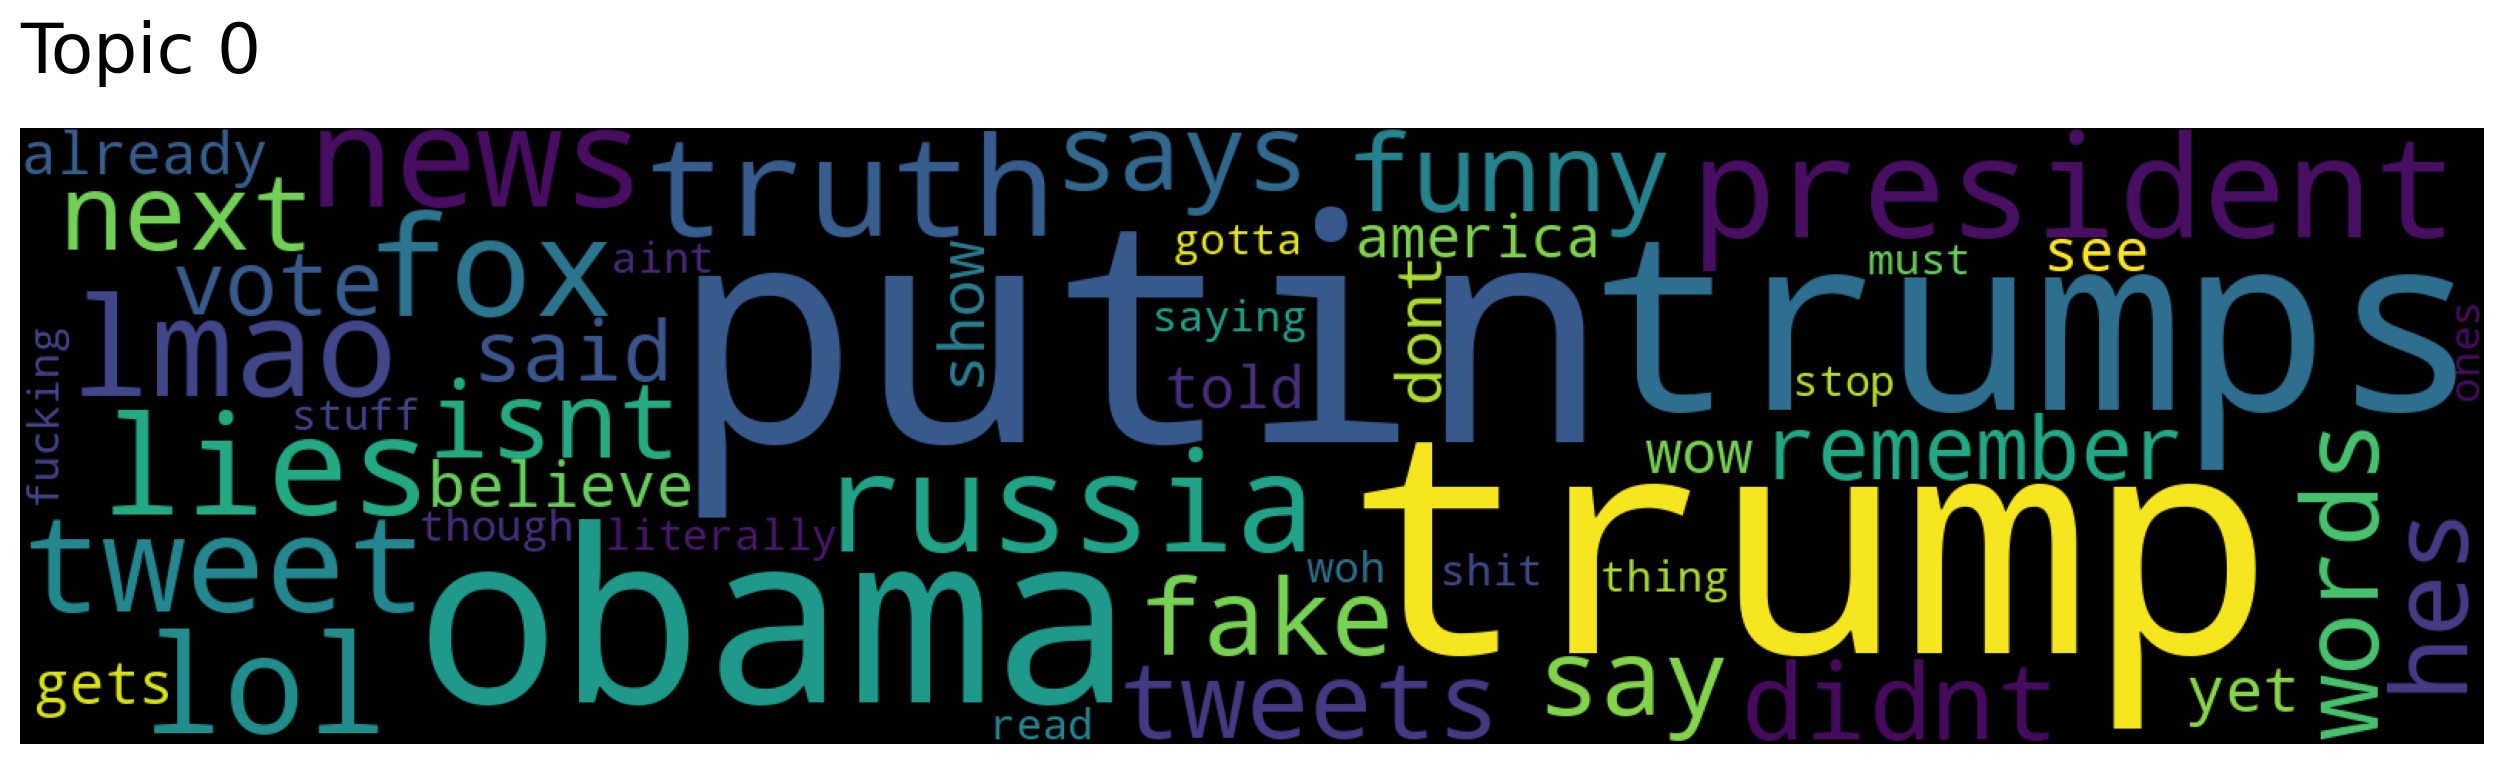

In [ ]:
top2vec_model.generate_topic_wordcloud(topic_num=0)

In [ ]:
docs, doc_scores, doc_ids = top2vec_model.search_documents_by_topic(topic_num=0, num_docs=5)
for doc in docs:
    print(doc)

well lets look comey putin lying trump joe mika fox fake news long line putintrump seg
dan watched tonight repoeranchors danced aroundfumbled issue trump putin tell lies hack america thanks
joe youre going leaks administration office hey joe putin stolehacked usa u putin kind promotion
trump lavishes presputin praise day new sanctions voted trump voted putin also way go youll suckers
turn let propagandist joe scarborough put trumpputin lies h


Top2Vec picked up a cluster of political discourse (Topic 0), indicating a significant volume of mental health-related posts are framed within political events, misinformation, and public figures like Trump. However, these topics may represent noise when the goal is to focus on personal experiences.

There is a need to remove noise. We will try two options:
(1) Analyze more topics
(2)Filter out trump in topic 0 and re-run Top2Vec Model

## **Option 1 - Analyze more topics**

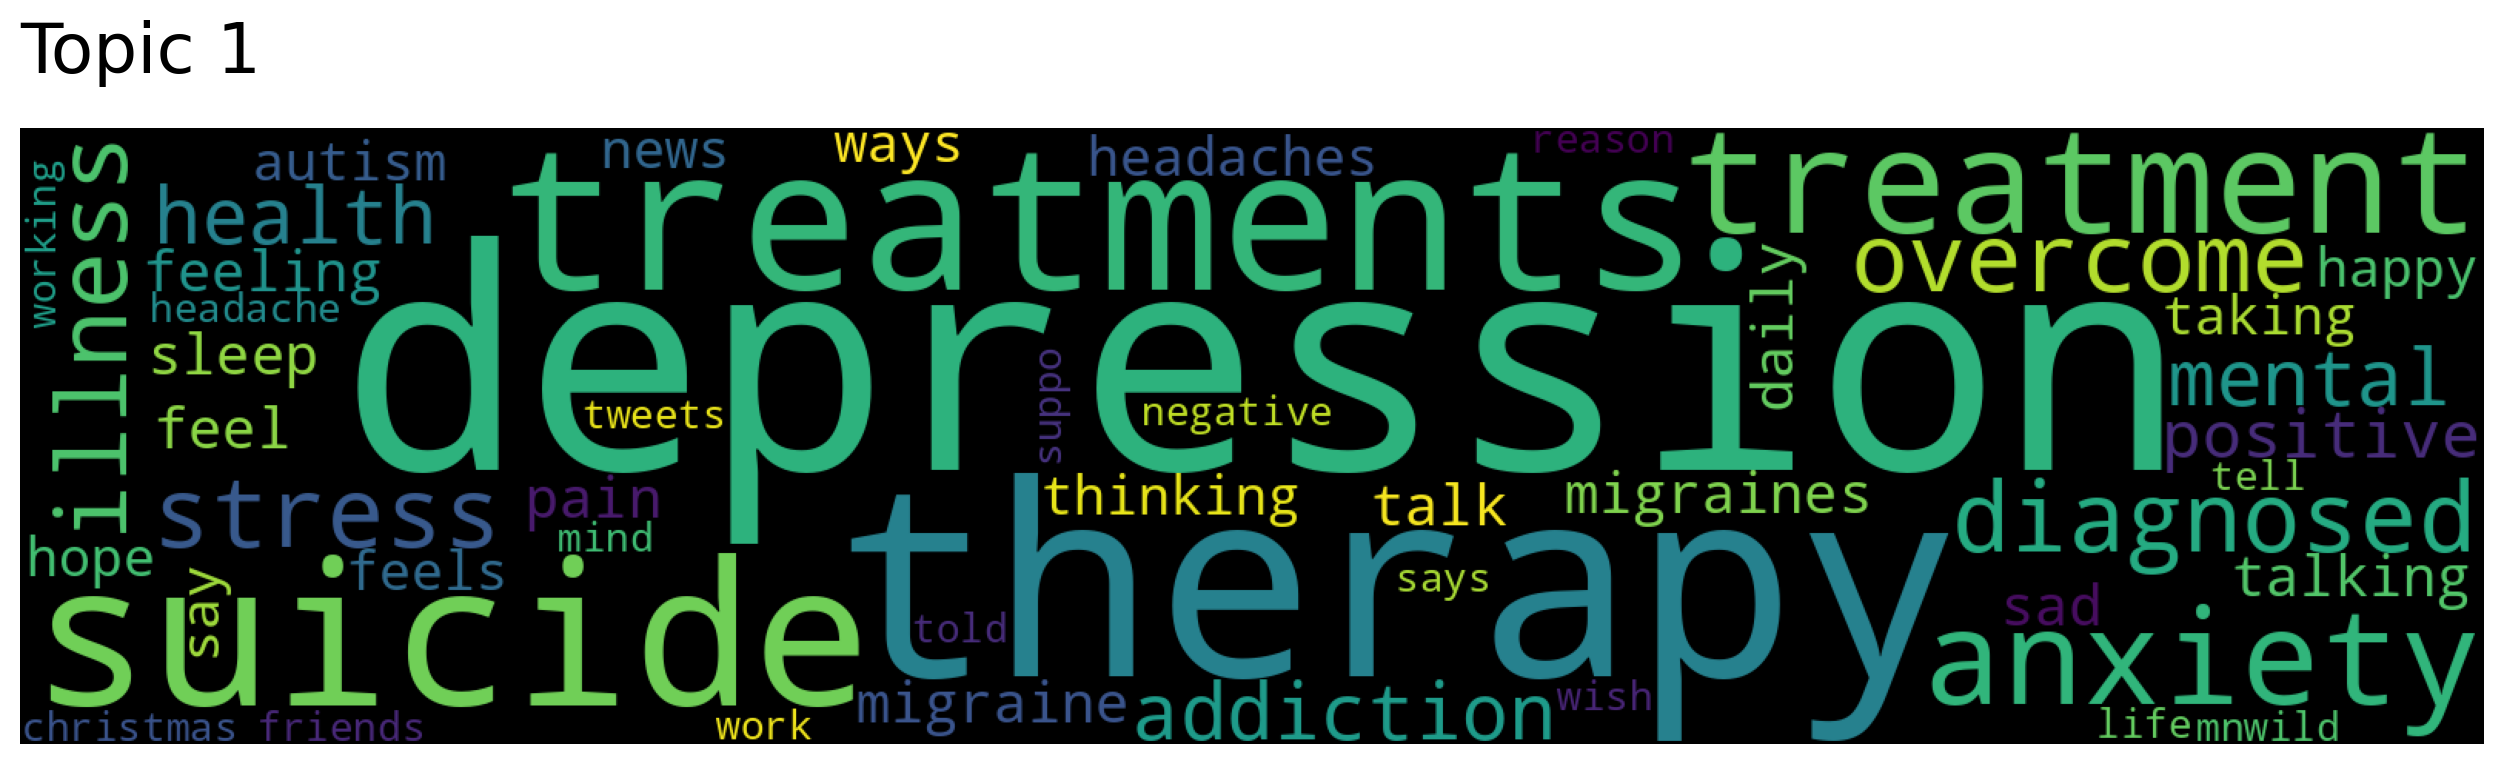

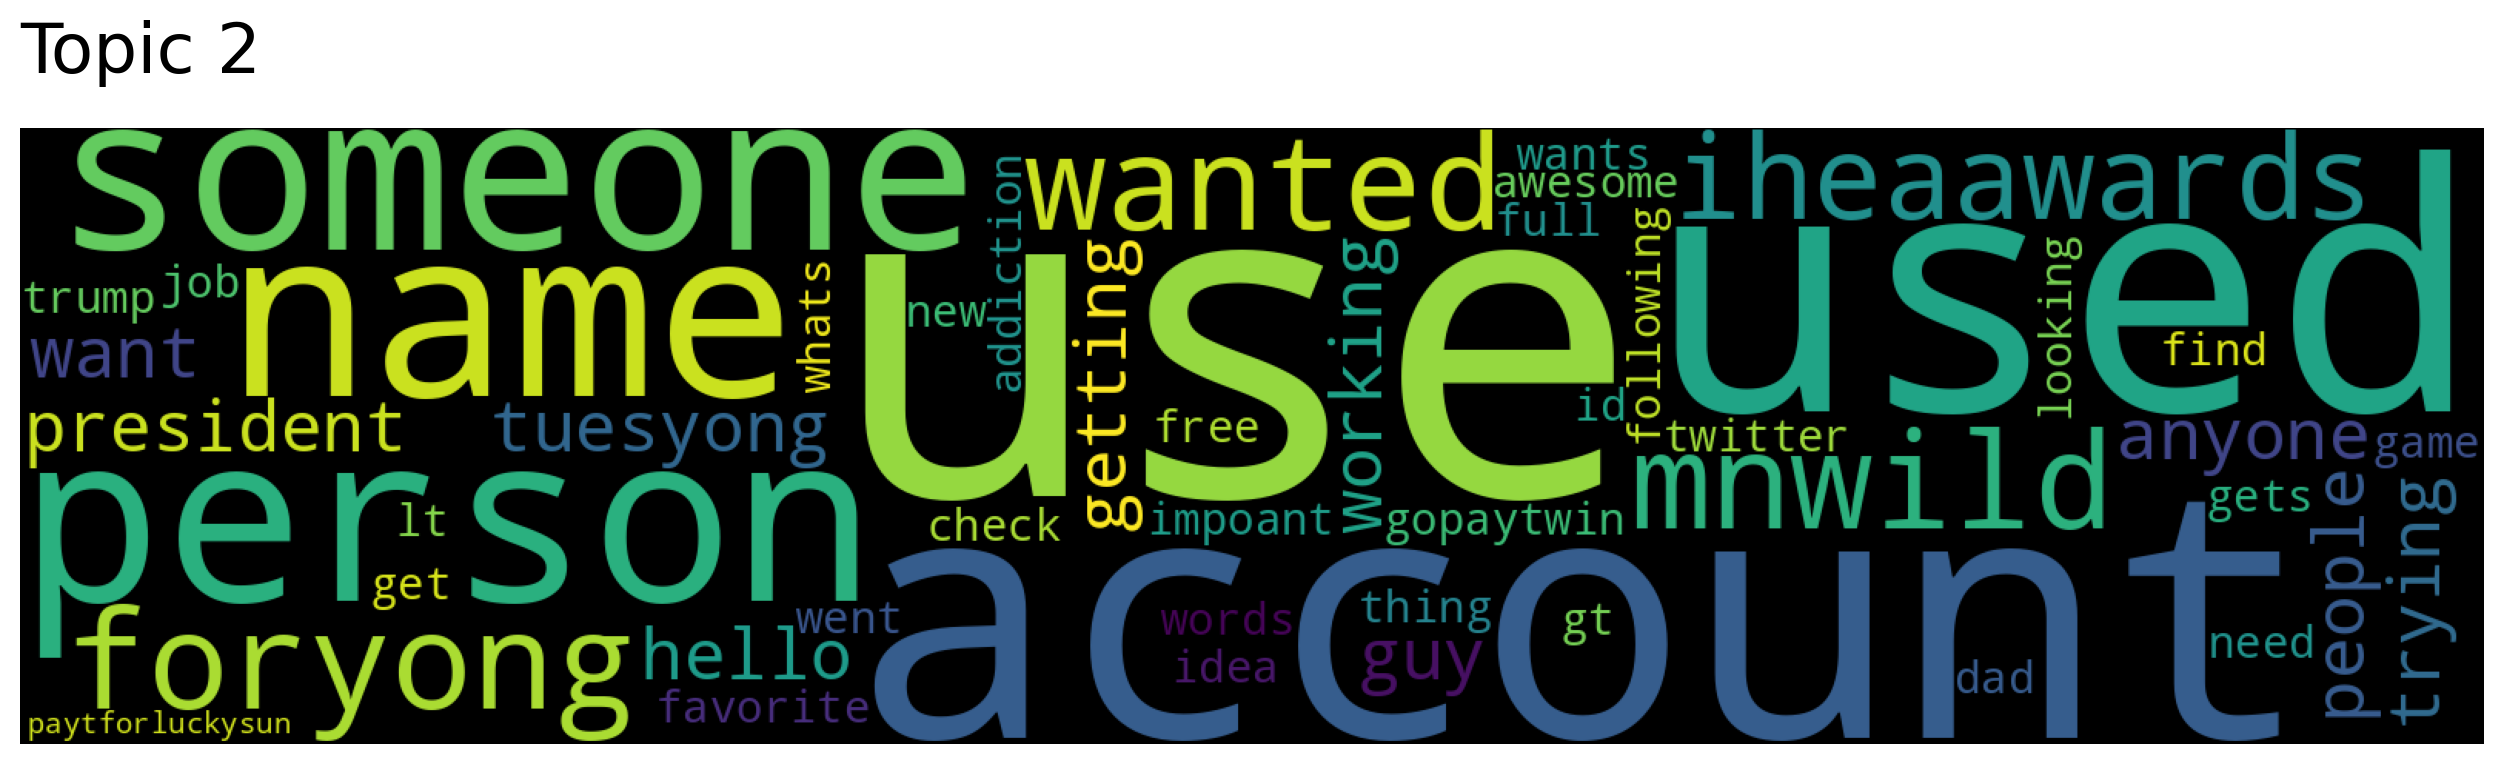

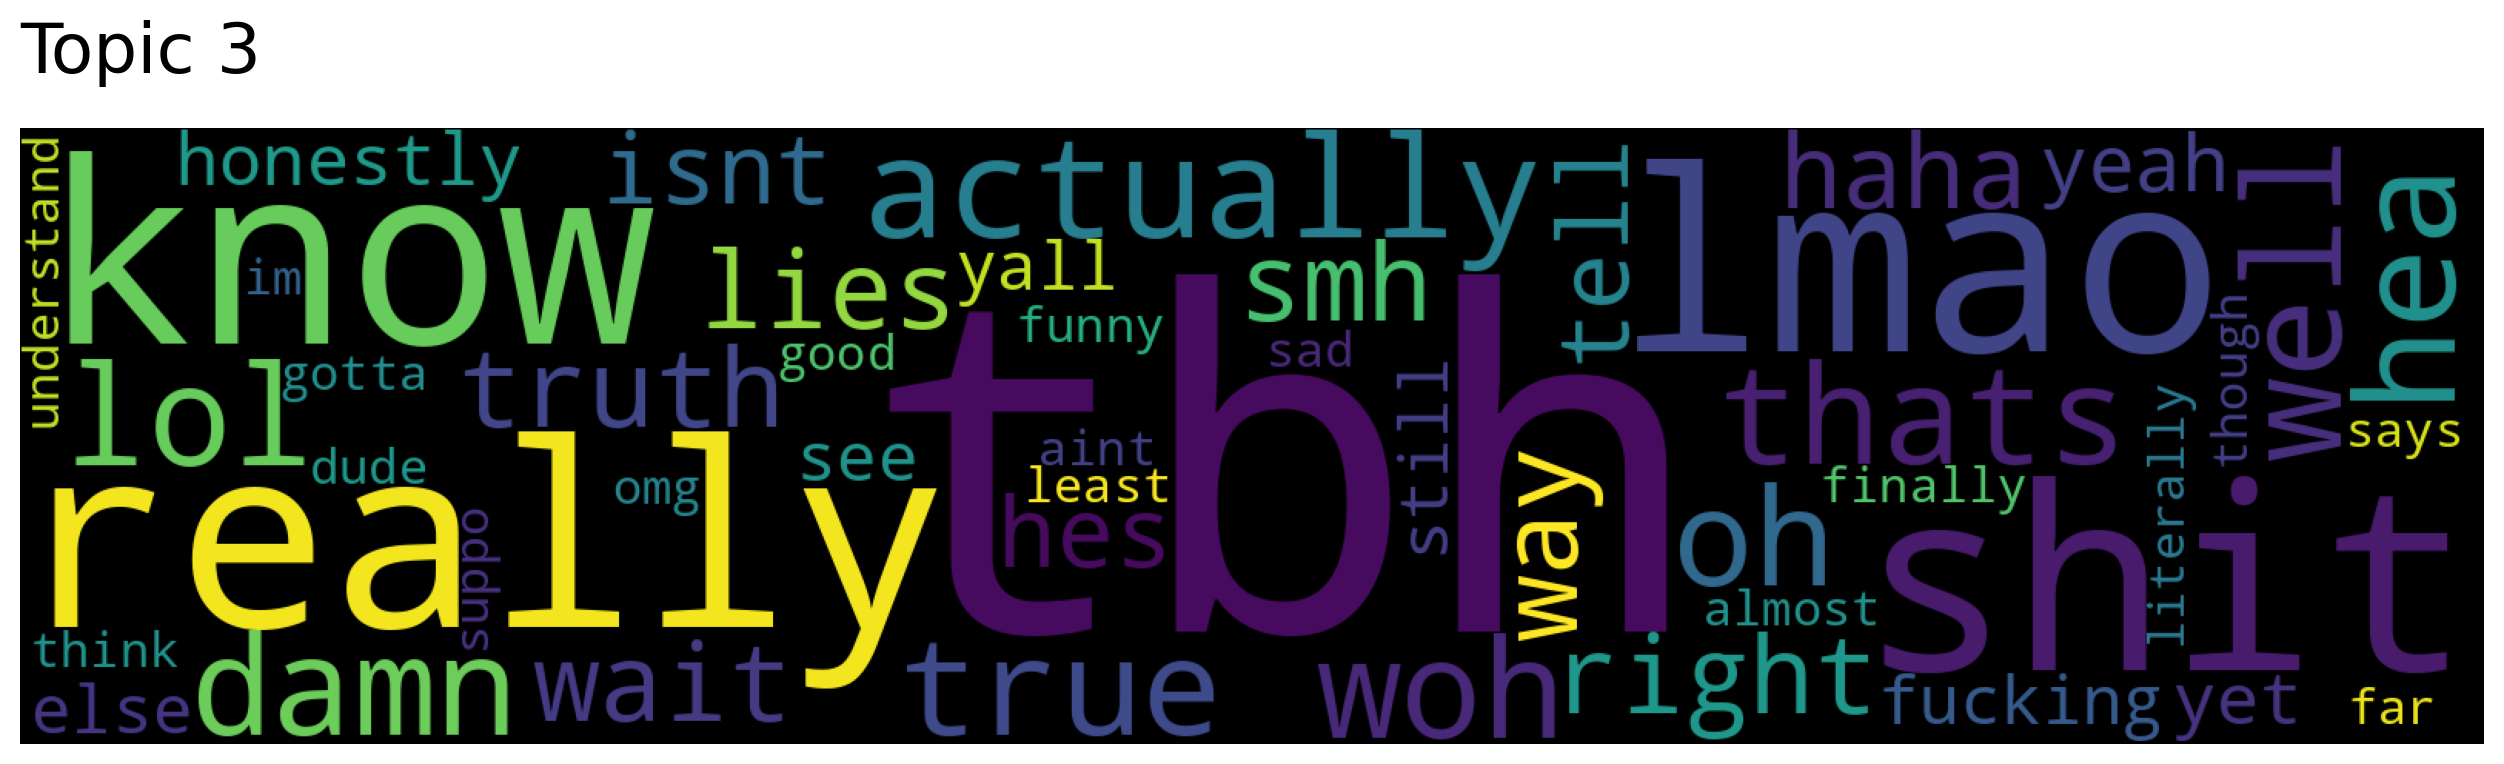

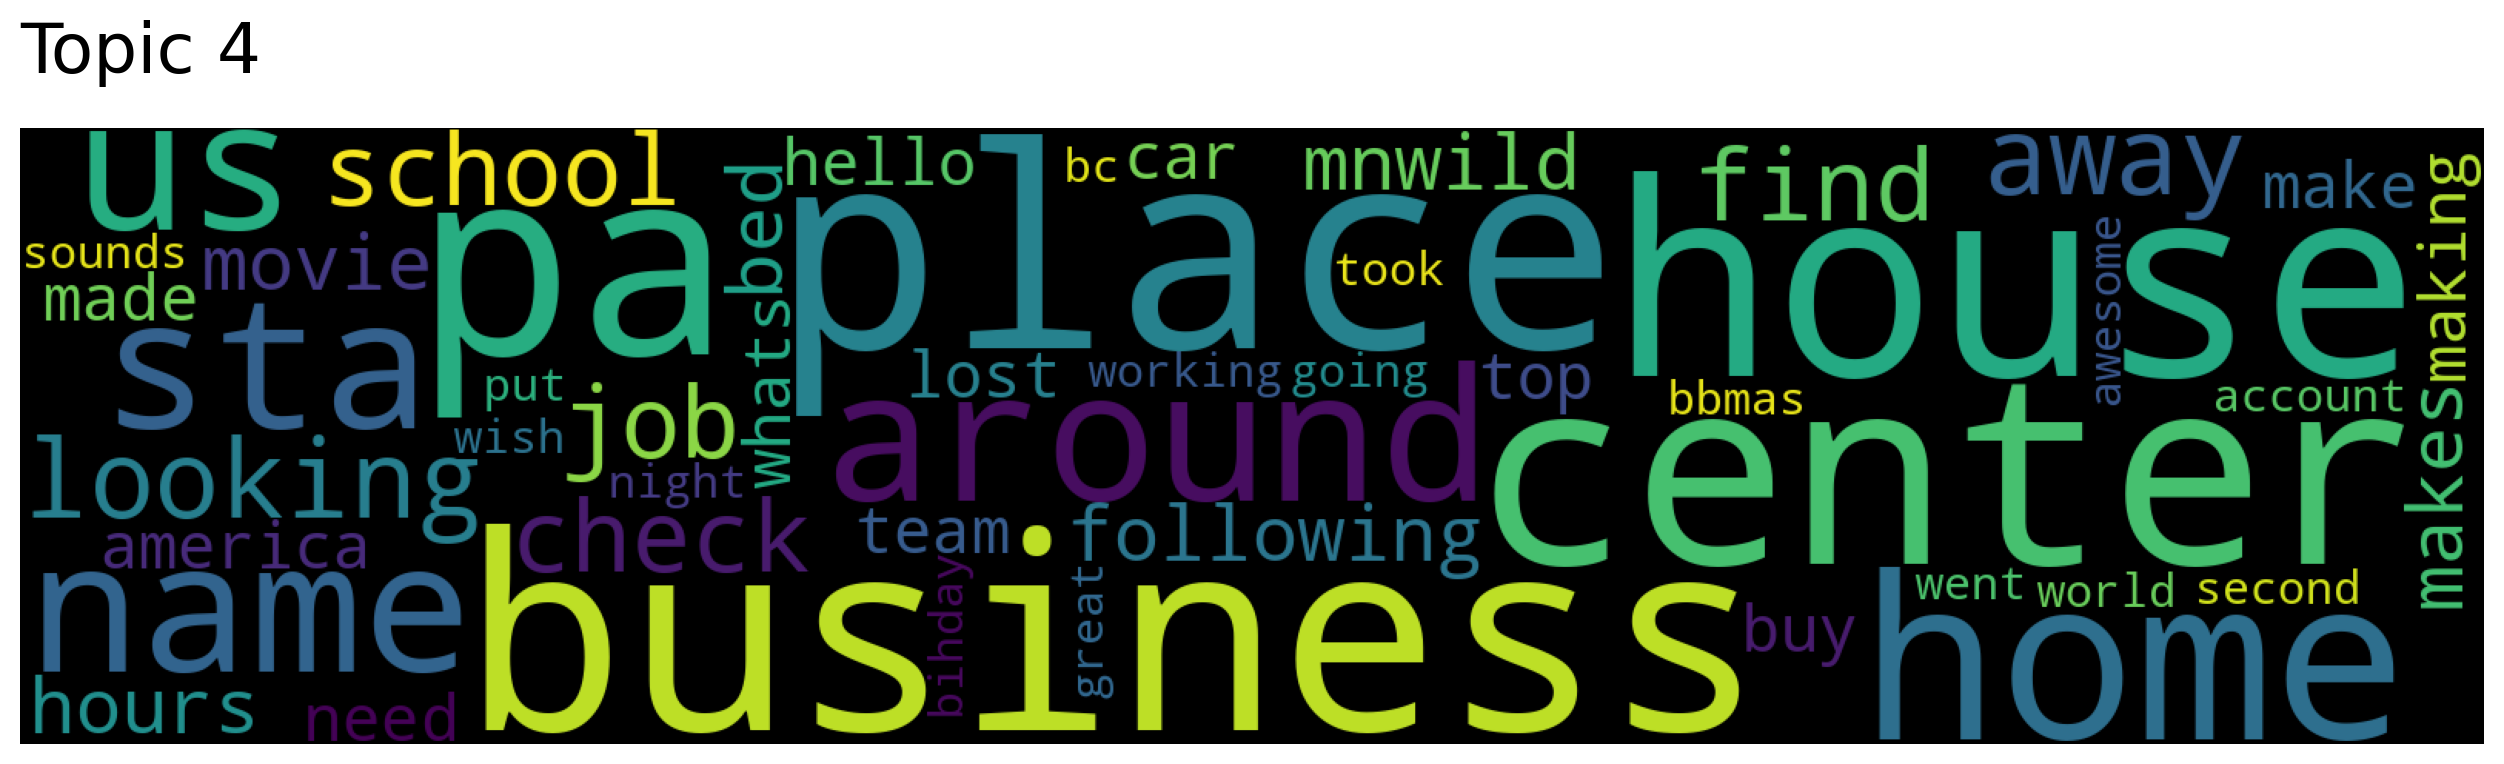

In [ ]:
# Try showing word clouds for other topic numbers
for i in range(1, 5):
    top2vec_model.generate_topic_wordcloud(topic_num=i)

In [ ]:
docs, _, _ = top2vec_model.search_documents_by_topic(topic_num=2, num_docs=3)
for doc in docs:
    print(doc)

userhelionne
useraustindish
usermike


## **Option 2 filter out Trump-related tweets & re-run Top2vec model**

In [ ]:
df_filtered = df[~df['filtered_text'].str.contains("trump|russia|biden|vote", case=False, na=False)]


In [ ]:
unwanted_terms = "trump|russia|biden|obama|vote|president|hillary|putin"
df_filtered = df[~df['filtered_text'].str.contains(unwanted_terms, case=False, na=False)]

# Optional: Reset index for clean display
df_filtered = df_filtered.reset_index(drop=True)

# Confirm new shape
print("Filtered dataset size:", df_filtered.shape)

Filtered dataset size: (19205, 14)


In [ ]:
top2vec_model_filtered = Top2Vec(
    documents=df_filtered['filtered_text'].tolist(),
    speed="learn",
    workers=4
)

2025-07-19 03:56:40,184 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-07-19 03:56:43,246 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
INFO:top2vec:Downloading all-MiniLM-L6-v2 model
2025-07-19 03:56:44,602 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-07-19 03:59:26,745 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-07-19 03:59:46,603 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

In [ ]:
# View number of topics found
print("Number of topics:", top2vec_model_filtered.get_num_topics())

# Display top words in each topic
topics, words, _ = top2vec_model_filtered.get_topics()
for i in range(min(5, len(topics))):
    print(f"Topic {i}: {words[i]}")

Number of topics: 192
Topic 0: [0.7806126  0.53381026 0.45549676 0.4476351  0.43154582 0.41121584
 0.38099664 0.3695181  0.36788982 0.3560484  0.34562874 0.33801264
 0.3262692  0.28102607 0.25862613 0.24793209 0.22715361 0.22539406
 0.22335045 0.22055563 0.21800466 0.21773477 0.21747099 0.21717665
 0.21602023 0.21358228 0.20531917 0.20393302 0.20172837 0.19697899
 0.19681239 0.19371389 0.18845528 0.18793043 0.18692854 0.18450288
 0.18288831 0.18259385 0.18204582 0.17334571 0.17193106 0.17106515
 0.16887209 0.16517535 0.1625709  0.16213685 0.16083613 0.16066433
 0.15987073 0.15954846]
Topic 1: [0.5156688  0.5106644  0.48779523 0.47190222 0.47142115 0.43686193
 0.42593688 0.4139348  0.413886   0.41345155 0.40735307 0.4027316
 0.40082598 0.39744195 0.3949839  0.39322513 0.3929574  0.39178467
 0.39165765 0.38863665 0.38695523 0.38209462 0.37822396 0.37597364
 0.37457943 0.374477   0.37165374 0.37164265 0.3716135  0.36752796
 0.36689025 0.3634966  0.36053392 0.3603537  0.35800448 0.35691738

depression treatments
depression treatments
done depression depression treatments


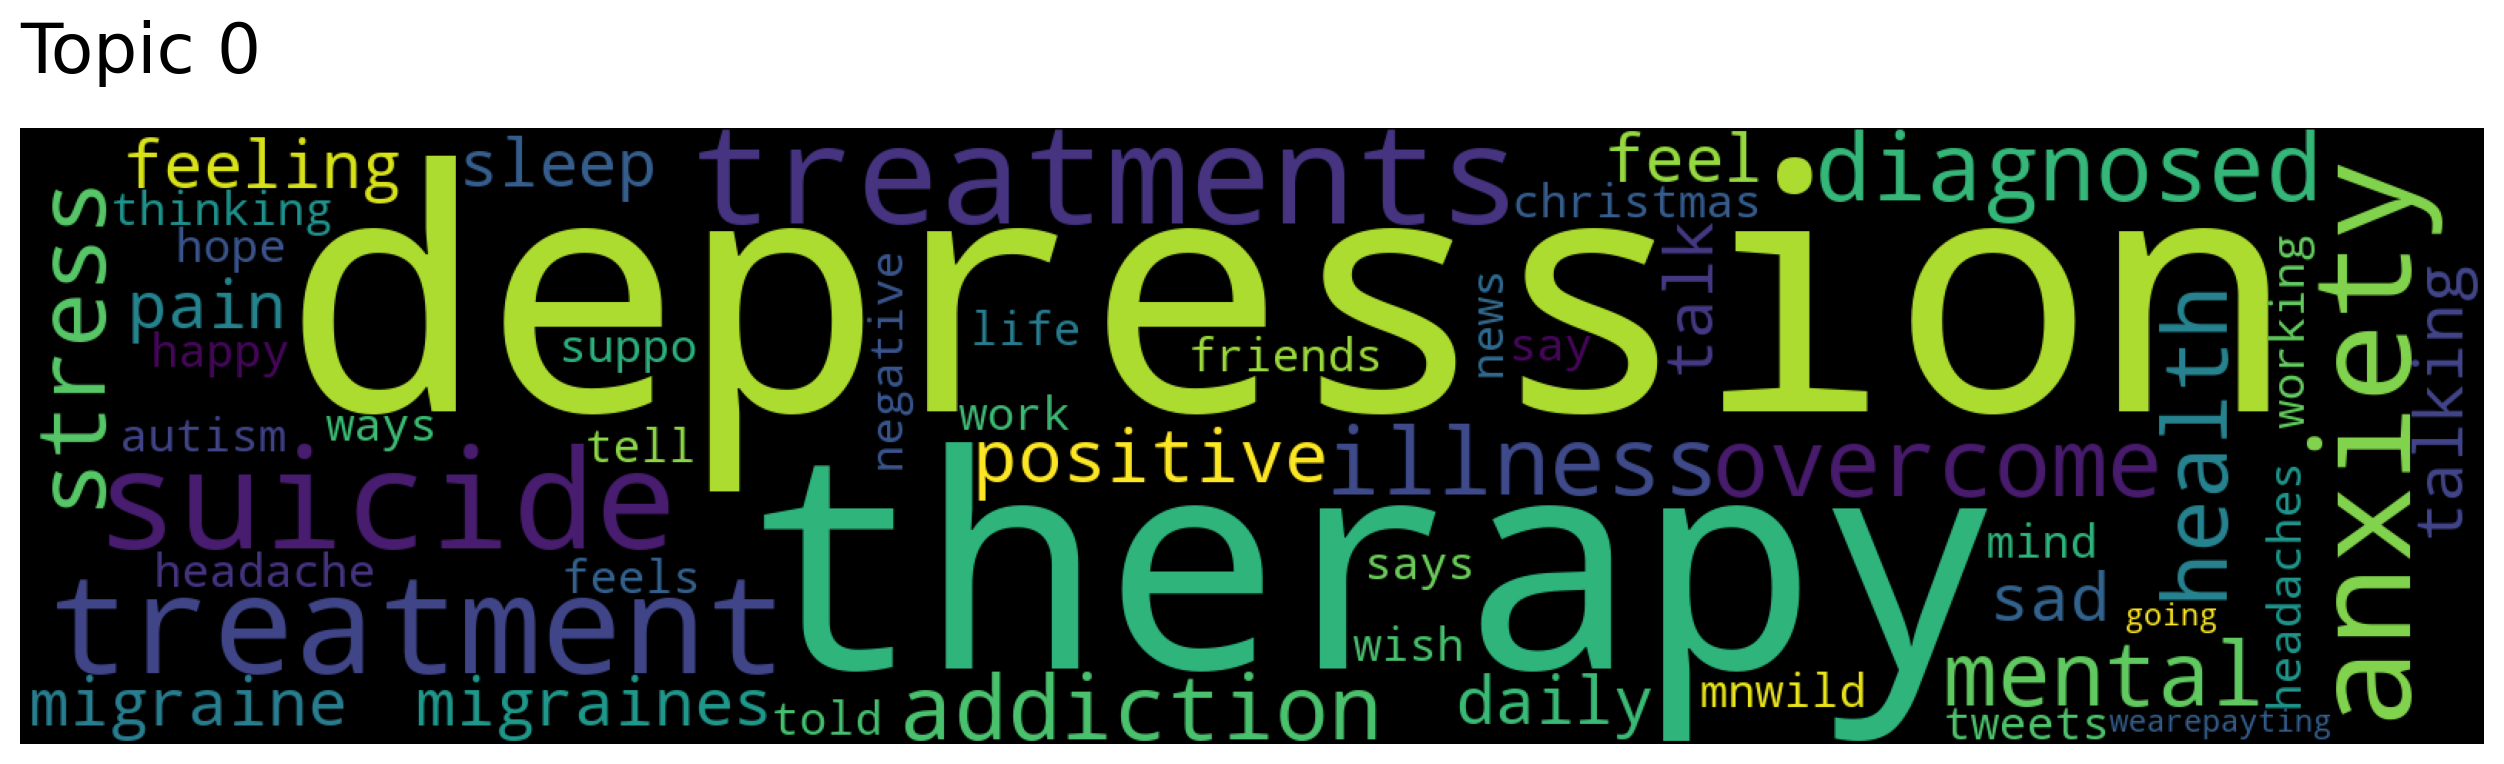

In [ ]:
# Word cloud for a specific topic
top2vec_model_filtered.generate_topic_wordcloud(topic_num=0)

# Preview example tweets from Topic 0
docs, _, _ = top2vec_model_filtered.search_documents_by_topic(topic_num=0, num_docs=3)
for doc in docs:
    print(doc)

Step 4 - Topic Modeling with Gensim

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download punkt_tab

# Tokenize and clean
stop_words = set(stopwords.words('english'))
texts = df_filtered['filtered_text'].dropna().astype(str).tolist()
tokenized_texts = [
    [word for word in word_tokenize(doc.lower()) if word.isalpha() and word not in stop_words]
    for doc in texts
]

# STEP 2: Create dictionary and corpus
from gensim import corpora

dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# STEP 3: Train the LDA model
from gensim.models.ldamodel import LdaModel

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,  # can try tuning this (5-10)
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# STEP 4: Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Topic 0: 0.057*"thank" + 0.029*"follow" + 0.014*"stay" + 0.014*"night" + 0.013*"charge" + 0.013*"flow" + 0.011*"go" + 0.010*"get" + 0.009*"right" + 0.007*"mark"
Topic 1: 0.036*"thanks" + 0.018*"safe" + 0.017*"month" + 0.017*"meant" + 0.013*"know" + 0.011*"ships" + 0.010*"love" + 0.009*"h" + 0.008*"always" + 0.007*"nothing"
Topic 2: 0.055*"say" + 0.054*"twitter" + 0.052*"following" + 0.047*"hello" + 0.027*"anytime" + 0.017*"god" + 0.012*"best" + 0.011*"life" + 0.010*"law" + 0.008*"world"
Topic 3: 0.023*"like" + 0.019*"hey" + 0.019*"never" + 0.018*"man" + 0.016*"dont" + 0.014*"one" + 0.013*"people" + 0.012*"im" + 0.011*"day" + 0.009*"piece"
Topic 4: 0.021*"without" + 0.019*"black" + 0.015*"real" + 0.010*"video" + 0.008*"need" + 0.008*"thing" + 0.007*"two" + 0.007*"look" + 0.007*"even" + 0.006*"city"


In [ ]:
!pip install pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.0 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.206639 -0.092891       1        1  31.920841
0      0.022093  0.147033       2        1  19.519895
2      0.158535 -0.149379       3        1  18.601790
1      0.012878  0.048401       4        1  15.022800
4      0.013134  0.046836       5        1  14.934674, topic_info=            Term         Freq        Total Category  logprob  loglift
825        thank  1358.000000  1358.000000  Default  30.0000  30.0000
49           say  1249.000000  1249.000000  Default  29.0000  29.0000
529      twitter  1206.000000  1206.000000  Default  28.0000  28.0000
2493   following  1193.000000  1193.000000  Default  27.0000  27.0000
2959       hello  1058.000000  1058.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4881          da    45.742240    46.748106   Topic5  -5.9798   1.8797
6032      taylor    79.503382    81.271841   Topic5  -5.4271   1.8795
1667    services    60.931557    64.705804   Topic5  -5.6931   1.8414
17698       yong    71.289159   424.988270   Topic5  -5.5361   0.1162
18039      holes    55.881719   302.763255   Topic5  -5.7796   0.2118

[202 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
85        5  0.985200     also
153       4  0.994724   always
530       4  0.988588  another
2209      1  0.038064  anytime
2209      2  0.029280  anytime
...     ...       ...      ...
9045      1  0.864623     zayn
9045      2  0.035911     zayn
9045      3  0.035911     zayn
9045      4  0.033148     zayn
9045      5  0.033148     zayn

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])